In [2]:
#import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from skimage import feature


In [ ]:
#might not be necessary?
import matplotlib.patches as patches
from astropy.table import Table
from itertools import compress
from statistics import mode

In [504]:
#navigate to event file location
%cd Desktop/SL_Analysis/40111002002/event_cl/

/Users/ellenthompson/Desktop/SL_Analysis/40111002002/event_cl


In [266]:
##define variables 
name_of_event_file = "nu40111002002A01_cl.evt"
bin_width = 10
bin_height = 10
energy_cut_channel_min = 36
energy_cut_channel_max = 209

#detector array edges 
left_edge = 20
right_edge = 340
bottom_edge = 20
top_edge = 340

#region file parameters (style options set to DS9 default)
parameters_string = "#Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font= 'helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n\npolygon"

#region file titles will include respective detectors, just put event file name/nickname here
region_file_title = "40111002002A01"

In [23]:
#open data
hdul = fits.open(name_of_event_file)

#move into 2nd hdu
data = hdul[1].data

#make table of columns
#tab = Table(data).columns

#define variables for det1x, det1y, and detid columns
DET1X = data["DET1X"]
DET1Y = data["DET1Y"]
DET_ID = data["DET_ID"]
PI = data["PI"]

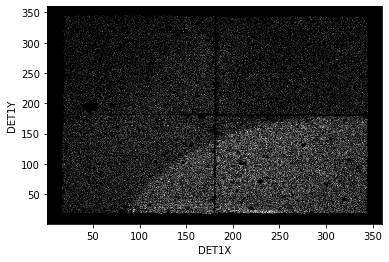

In [24]:
#visualize data
image_name = '40111002002A01'
NBINS=(360,360)
fig,ax = plt.subplots(1)
ax.hist2d(DET1X, DET1Y, NBINS, range=[[1, 360], [1,360]], cmap='gray')
ax.set_xlabel('DET1X')
ax.set_ylabel('DET1Y')
plt.show()

In [103]:
from scipy import ndimage
det1x_gauss = ndimage.gaussian_filter(DET1X, sigma = 0.4)
det1y_gauss = ndimage.gaussian_filter(DET1Y, sigma = 0.4)

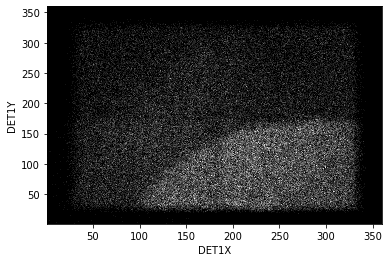

In [104]:
NBINS=(360,360)
fig,ax = plt.subplots(1)
ax.hist2d(det1x_gauss, det1y_gauss, NBINS, range=[[1, 360], [1,360]], cmap='gray')
ax.set_xlabel('DET1X')
ax.set_ylabel('DET1Y')
plt.show()

## SL Threshold Identification

- Tried energy cut, doesn't smooth
- Tried working with astropy.convolution, got dimensional errors
- Scipy image smoothing
    - Axes separate
    - Need math modeling to identify threshold?
- Scikit-image (skimage) : **Identifies Region**



In [30]:
#energy cut using PI column (background varies more across high than low energies)
del_PI_indices = [i for i, x in enumerate(PI) if x<=energy_cut_channel_min or x>=energy_cut_channel_max]
cut_DET1X = np.delete(DET1X, del_PI_indices)
cut_DET1Y = np.delete(DET1Y, del_PI_indices)

#create counts array of energy cut bins, use known DET1X and DET1Y ranges
cut_counts_arrays = np.histogram2d(cut_DET1X, cut_DET1Y, [int(360/bin_width),int(360/bin_height)],range=[[1,360],[1,360]])
cut_bin_counts = np.hstack(cut_counts_arrays[0])

#SL threshold = max bin count value of energy cut bins
#threshold = 250

In [46]:
#DIVIDE EVENTS BY DETECTOR

DetID0 = [i for i, x in enumerate(DET_ID) if x == 0]
DetID1 = [i for i, x in enumerate(DET_ID) if x == 1]
DetID2 = [i for i, x in enumerate(DET_ID) if x == 2]
DetID3 = [i for i, x in enumerate(DET_ID) if x == 3]

X_DetID0 = [DET1X[i] for i in DetID0]
Y_DetID0 = [DET1Y[i] for i in DetID0]

X_DetID1 = [DET1X[i] for i in DetID1]
Y_DetID1 = [DET1Y[i] for i in DetID1]

X_DetID2 = [DET1X[i] for i in DetID2]
Y_DetID2 = [DET1Y[i] for i in DetID2]

X_DetID3 = [DET1X[i] for i in DetID3]
Y_DetID3 = [DET1Y[i] for i in DetID3]    

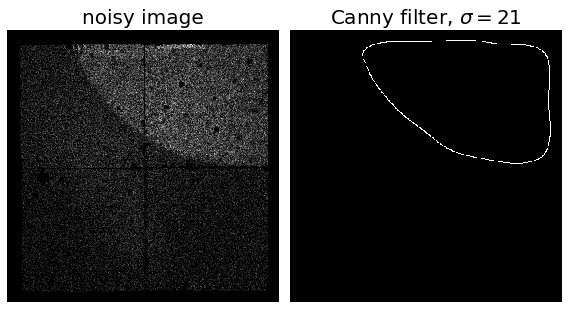

In [491]:
#CANNY EDGE DETECTOR FOR FULL REGION
counts_arrays = np.histogram2d(DET1X, DET1Y,[360,360],range=[[0,360],[0,360]])
bin_counts = np.hstack(counts_arrays[0])
bin_counts_binned = np.split(bin_counts,360)
im = np.column_stack(bin_counts_binned)

#im = ndi.rotate(im,90)

# Compute the Canny filter for two values of sigma
edges = feature.canny(im, sigma=21)

# display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=21$', fontsize=20)

fig.tight_layout()

plt.show()

In [1]:
indices = np.where(edges != [0])
coordinates = zip(indices[1], indices[0])
coords_list = list(coordinates)
corners = np.hstack(coords_list)
#corners = np.transpose(corners)


NameError: name 'np' is not defined

In [ ]:
x_coords = list(indices[1])
y_coords = list(indices[0])

bottom_edge = min(y_coords)
right_edge = max(x_coords)

lower_left_x = min(x_coords)
lower_left_y = min(y_coords)


In [480]:
##identify region polygon corners 

#list region "columns" by deleting duplicate x coords 
region_cols = list(set(x_coords)) 

#find SL curve perimeter coords
curve_perimeter_coords = []
for i in region_cols:
    if i in curve_perimeter_coords:
            pass
    else:
        curve_perimeter_coords.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords.append(max(y_coords_for_i))

In [494]:
curve_perimeter_coords[-1]

140

In [499]:
corners = []
for i in curve_perimeter_coords:
    corners.append(i)

upper_right_x = right_edge
upper_right_y = curve_perimeter_coords[-1]

lower_right_x = max(x_coords)
lower_right_y = min(y_coords)

edge_corners = (upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y)

for i in edge_corners:
    corners.append(i)
    

In [487]:
len(corners)

506

In [460]:


#determine region edges depending on which corner the SL region is on 
if mode(all_det_ids_list) == 3:
    lower_right_y = bottom_edge
    lower_left_y = bottom_edge

    
upper_left_x = (min(det_2_bins)//(360/bin_width))*bin_width
upper_left_y = (min(det_2_bins)%(360/bin_height)*bin_height)+bin_height

corners = [upper_left_x,upper_left_y]



for i in curve_perimeter_bins:
    corners.append((i//(360/bin_width))*bin_width)
    corners.append((i%(360/bin_height)*bin_height)+bin_height)

upper_right_x = corners[-2] + bin_width
upper_right_y = corners[-1]
lower_right_x = ((max(det_2_bins)//(360/bin_width))*bin_width)+bin_width
lower_left_x = upper_left_x

corners.append(upper_right_x)
corners.append(upper_right_y)
corners.append(lower_right_x)
corners.append(lower_right_y)
corners.append(lower_left_x)
corners.append(lower_left_y)

SyntaxError: invalid syntax (<ipython-input-460-e068f1113b9b>, line 13)

In [387]:
for i in coords_list:
    if i[0]<20 or i[0]>340 or  i[1]<20 or i[1]>340:
        coords_list.remove(i)

In [382]:
corners = np.hstack(coords_list)

In [259]:
##identify region polygon corners 

#list region columns 
x_coords = [] 
for i in :
    x = (i//(360/bin_width))*bin_width
    if x in det_2_bins_cols: 
        pass 
    else:
        det_2_bins_cols.append(x)

#find SL curve perimeter bins
curve_perimeter_bins = []
for i in det_2_bins_cols:
    column_bins = []
    for bin in det_2_bins:
        if (bin//(360/bin_width)*bin_width) != i:
            pass
        if (bin//(360/bin_width)*bin_width) == i:
            column_bins.append(bin)
    curve_perimeter_bins.append(max(column_bins))

#determine region edges depending on which corner the SL region is on 
if mode(all_det_ids_list) == 3:
    lower_right_y = bottom_edge
    lower_left_y = bottom_edge

    
upper_left_x = (min(det_2_bins)//(360/bin_width))*bin_width
upper_left_y = (min(det_2_bins)%(360/bin_height)*bin_height)+bin_height

corners = [upper_left_x,upper_left_y]



for i in curve_perimeter_bins:
    corners.append((i//(360/bin_width))*bin_width)
    corners.append((i%(360/bin_height)*bin_height)+bin_height)

upper_right_x = corners[-2] + bin_width
upper_right_y = corners[-1]
lower_right_x = ((max(det_2_bins)//(360/bin_width))*bin_width)+bin_width
lower_left_x = upper_left_x

corners.append(upper_right_x)
corners.append(upper_right_y)
corners.append(lower_right_x)
corners.append(lower_right_y)
corners.append(lower_left_x)
corners.append(lower_left_y)

In [376]:
#trying cutting edges off
x_coords_cut = [x for x in coords_list[x][0] if 20 <= x[0] <= 340]
y_coords_cut = [y for y in coords_list if 20 <= y[1] <= 340]
coordinates = zip(x_coords, y_coords)
coords_list = list(coordinates)
corners = np.hstack(coords_list)

TypeError: 'numpy.int64' object is not iterable

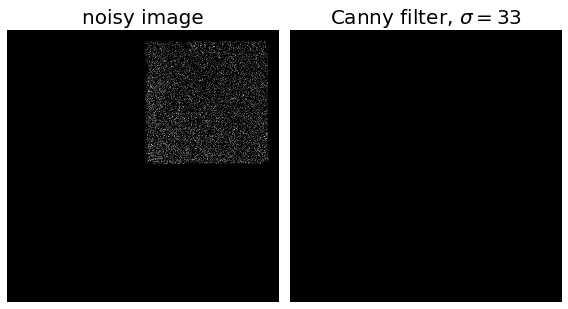

In [331]:
##CANNY EDGE DETECTOR BY DETECTOR

counts_arrays = np.histogram2d(Y_DetID0, X_DetID0, [360,360], range=[[0,360],[0,360]])
bin_counts = np.hstack(counts_arrays[0])
bin_counts_binned = np.split(bin_counts,360)
im = np.column_stack(bin_counts_binned)

im = ndi.rotate(im,90)

# Compute the Canny filter for two values of sigma
det3_edges = feature.canny(im, sigma=33)

# display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(det3_edges, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=33$', fontsize=20)

fig.tight_layout()

plt.show()

In [283]:
indices = np.where(det3_edges != [0])
coordinates = zip(indices[1], indices[0])
coords_list = list(coordinates)
corners = np.hstack(coords_list)

## Identify SL Bins

In [195]:
#create counts array of original bins, use known DET1X and DET1Y ranges
counts_arrays = np.histogram2d(DET1X, DET1Y,  [int(360/bin_width),int(360/bin_height)],range=[[1,360],[1,360]])
bin_counts = np.hstack(counts_arrays[0])

#identify bin neighbors to avoid bright background spot being counted as SL
def neighbors(i):
    neighbors_array = []
    for neighbor in [i+1, i-1, i-36, i+36]:
        neighbors_array.append(bin_counts[neighbor % len(bin_counts)])
    return neighbors_array

#boolean region test
def region_test(i):
    if neighbors(i)[0] >= threshold or neighbors(i)[1] >= threshold or neighbors(i)[2] >= threshold or neighbors(i)[3] >= threshold:
        i = True
    else: i = False
    return i

#make array of passing bin indices
region_bins = [i for i, x in enumerate(bin_counts) if region_test(i)]


NameError: name 'threshold' is not defined

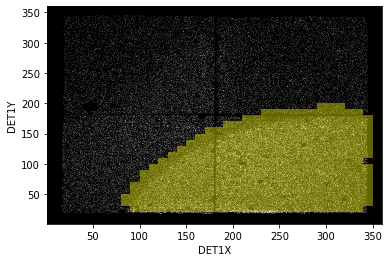

In [71]:
#region bins visualization 
indices = range(1, 1295, 1)
NBINS=(360,360)
fig,ax = plt.subplots(1)
ax.hist2d(data['DET1X'], data['DET1Y'], NBINS, range=[[1, 360], [1,360]], cmap='gray')
ax.set_xlabel('DET1X')
ax.set_ylabel('DET1Y')
for i in region_bins:
    cornerx = (indices[i]// 36)*10
    cornery = (indices[i] % 36)*10
    SL = patches.Rectangle((cornerx,cornery), 10, 10, edgecolor='none', facecolor='yellow', alpha = 0.4)
    ax.add_patch(SL)
#plt.savefig('region.png')
plt.show()

Next Step: Divide region bins by detector

In [235]:
#find det ids for all events in a bin
def det_ids_for_bin(bin):
    xlower = (bin//(360/bin_width))*bin_width
    xupper = xlower +bin_width
    ylower = (bin%(360/bin_height))*bin_height
    yupper = ylower + bin_height
    x = tab['DET1X']
    y = tab['DET1Y']
    events_indices = np.argwhere((x > xlower) & (x < xupper) & (y > ylower) & (y < yupper))
    events_indices_list_of_lists = [arr.tolist() for arr in events_indices]
    events_indices_flat_list = []
    for sublist in events_indices_list_of_lists:
        for item in sublist:
            events_indices_flat_list.append(item)
    det_ids = []
    for i in events_indices_flat_list:
        det_ids.append(DET_ID[i])
    return det_ids

#remove bins split across detectors
all_det_ids = []
for bin in region_bins:
    all_det_ids.append(det_ids_for_bin(bin))
all_det_ids_list = []
for sublist in all_det_ids:
    for item in sublist:
        all_det_ids_list.append(item)

check_bins = []
for sublist in all_det_ids:
    d = sublist[0]
    if sublist.count(d) == len(sublist):
        check_bins.append(True)
    else:
        check_bins.append(False)

bad_bins = [i for i, val in enumerate(check_bins) if not val]

for i in bad_bins:
    region_bins.pop(i)
for i in bad_bins:
    all_det_ids.pop(i)

#make region lists by detector
det_0_bins = []
det_1_bins = []
det_2_bins = []
det_3_bins = []

for i in range(0,len(all_det_ids)):
    if all_det_ids[i][0] == 0:
        det_0_bins.append(region_bins[i])
    if all_det_ids[i][0] == 1:
        det_1_bins.append(region_bins[i])
    if all_det_ids[i][0] == 2:
        det_2_bins.append(region_bins[i])
    if all_det_ids[i][0] == 3:
        det_3_bins.append(region_bins[i])

The following cells only create the detector2 region file for this event
 - will write code for detector3 region for example event file
 - need to figure out how to get program to create region files only for detectors with SL   (it's a decision tree)

In [259]:
##identify region polygon corners 

#list region columns 
det_2_bins_cols = []
for i in det_2_bins:
    x = (i//(360/bin_width))*bin_width
    if x in det_2_bins_cols: 
        pass 
    else:
        det_2_bins_cols.append(x)

#find SL curve perimeter bins
curve_perimeter_bins = []
for i in det_2_bins_cols:
    column_bins = []
    for bin in det_2_bins:
        if (bin//(360/bin_width)*bin_width) != i:
            pass
        if (bin//(360/bin_width)*bin_width) == i:
            column_bins.append(bin)
    curve_perimeter_bins.append(max(column_bins))

#determine region edges depending on which corner the SL region is on 
if mode(all_det_ids_list) == 3:
    lower_right_y = bottom_edge
    lower_left_y = bottom_edge

    
upper_left_x = (min(det_2_bins)//(360/bin_width))*bin_width
upper_left_y = (min(det_2_bins)%(360/bin_height)*bin_height)+bin_height

corners = [upper_left_x,upper_left_y]



for i in curve_perimeter_bins:
    corners.append((i//(360/bin_width))*bin_width)
    corners.append((i%(360/bin_height)*bin_height)+bin_height)

upper_right_x = corners[-2] + bin_width
upper_right_y = corners[-1]
lower_right_x = ((max(det_2_bins)//(360/bin_width))*bin_width)+bin_width
lower_left_x = upper_left_x

corners.append(upper_right_x)
corners.append(upper_right_y)
corners.append(lower_right_x)
corners.append(lower_right_y)
corners.append(lower_left_x)
corners.append(lower_left_y)

In [500]:
#write region file
det2_region_file_title = region_file_title + "_canny_filter.reg"
det2_region_file = open(det2_region_file_title, "w")
det2_region_file.write(parameters_string + str(tuple(corners)))
det2_region_file.close()